<a href="https://colab.research.google.com/github/roalus/ai-projects/blob/main/OpenAI_Examples/CartPoleWithReinforcementLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This .

The work is based on the example

In [58]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [59]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [60]:
# Load libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from IPython import display as ipythondisplay

In [63]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 104 kB/s 


In [5]:
# Initialise environment
env = gym.make('CartPole-v1', new_step_api=True)

In [20]:
# Let's see the size of the action space (i.e. how many actions we can do) and 
# the size of the observation space (i.e. how many variables we can measure)
NUM_ACTIONS = env.action_space.n
print(NUM_ACTIONS)
print(env.observation_space)

2
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


*   Actions (2): 
  * Move cart left
  * Move cart right
*   Observation space (4):
  * Position of cart
  * Velocity of cart
  * Angle of pole
  * Angular velocity of pole

We can see that there are infinite number of states because the observations are continuous variables. For example, the position of the car can take any value in the range `[-4.8, +4.8]`. We need to discretise the space so we can apply Q-learning to a bounded space.




In [14]:
# Discretise the observation space in buckets. We don't care about the position 
# or the velocity of the cart so we simply leave that variable as a single 
# bucket. This is done to reduce the dimensionality of the problem. This will 
# make our learning much faster as our Q-table size is smaller
NUM_BUCKETS = (1, 1, 6, 3)

In [19]:
# Modify the boundaries of the problem in order to further limit our state space
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
print(STATE_BOUNDS)

[(-4.8, 4.8), (-3.4028235e+38, 3.4028235e+38), (-0.41887903, 0.41887903), (-3.4028235e+38, 3.4028235e+38)]


In [23]:
STATE_BOUNDS[1] = [-.5, .5]  # New boundary for the velocity of cart [m/s]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]  # New boundary for the velocity of cart [rad/s]
print(STATE_BOUNDS)

[(-4.8, 4.8), [-0.5, 0.5], (-0.41887903, 0.41887903), [-0.8726646259971648, 0.8726646259971648]]


Note that the CartPole environment in the OpenAI Gym already limits the state space for us. The episode ends when the cart moves more than 2.4 meters from the centre or when the angle of the pole is greater than 15° from the vertical.

In [67]:
# Initialise Q table
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,))
print(q_table.shape)
print(q_table)

(1, 1, 6, 3, 2)
[[[[[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]]]]


The first 4 dimensions represent the number of states. The last dimension is the number of actions.

In [28]:
# Define Reinforcement Learning parameters
EXPLORE_RATE_MIN = .01
LEARNING_RATE_MIN = .1

## Define helper functions

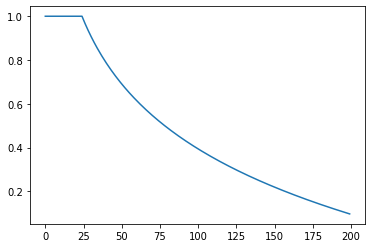

In [38]:
# Create a helper function to decay our exploration rate over time: we want to 
# explore less over time as we're more sure of getting the balance right
def get_explore_rate(t):
  return max(EXPLORE_RATE_MIN, min(1, 1.0-math.log10((t+1)/25)))
t_plot = range(200)
explore_rate_plot = [get_explore_rate(t) for t in t_plot]
plt.plot(t_plot, explore_rate_plot)

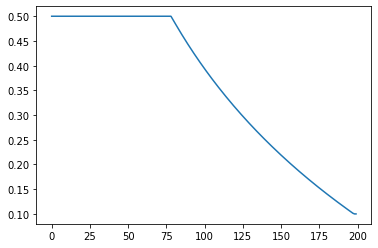

In [39]:
# Similarly we want to decay the learning rate as well so that we don't miss any
# maximums
def get_learning_rate(t):
  return max(LEARNING_RATE_MIN, min(0.5, 1.0-math.log10((t+1)/25)))
learning_rate_plot = [get_learning_rate(t) for t in t_plot]
plt.plot(t_plot, learning_rate_plot)

In [32]:
# Create a helper function to choose the action we want to take
def select_action(state, explore_rate):
  if random.random() < explore_rate:  # In the first cases, when the explore rate is high, we choose a random action
    action = env.action_space.sample()
  else:  # When we have more confidence in our learning, we choose the best action recorded in the Q table
    action = np.argmax(q_table[state])

  return action

In [90]:
# Create a helper function to assign a state to a bucket so that's easier to explore
# A state in the CartPole environment is represented using 4 observations (state variables)
def state_to_bucket(state):
  '''
  This function takes the continuous state information and returns a 
  discretised, bucketised version.
  '''
  bucket_indices = []
  for i in range(len(state)):
    if state[i] <= STATE_BOUNDS[i][0]:  # Below minimum threshold
      bucket_index = 0
    elif state[i] >= STATE_BOUNDS[i][1]:  # Above maximum threshold
      bucket_index = NUM_BUCKETS[i] - 1
    else:
      bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
      offset = (NUM_BUCKETS[i]-1) * STATE_BOUNDS[i][0] / bound_width
      scaling = (NUM_BUCKETS[i]-1) / bound_width
      bucket_index = int(round(scaling * state[i] - offset))

    bucket_indices.append(bucket_index)

  return tuple(bucket_indices)

In [55]:
# Example
sample_observation = [.5, -.1, 0.2, 0.1]
sample_state = state_to_bucket(sample_observation)
print(sample_state)

[0, 0, 4, 1]


## Set-up CartPole simulation

In [97]:
def simulate():
  # Initialise learning and explore rates
  learning_rate = get_learning_rate(0)
  explore_rate = get_explore_rate(0)
  # Define discount factor (aka gamm)
  discount_factor = .99  # Very close to 1: future rewards are almost as important as immediate rewards
  # Initialise the counter for consecutive successful episodes (i.e. without the pole falling)
  num_streaks = 0
  # Run simulation for 1000 episodes
  for episode in range(1000):
    # One episode finishes when
    # Reset observation
    observ = env.reset()
    state_0 = state_to_bucket(observ)
    # Run episode for up to 250 time instances
    for t in range(250):
      screen = env.render(mode='rgb_array')
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      # Select action
      action = select_action(state_0, explore_rate)
      # Perform action and observe, get reward and see if done. The reward is +1 if the pole hasn't fallen
      observ, reward, done, _, _ = env.step(action)
      # Translate observation into a discrete state
      state = state_to_bucket(observ)
      # Look up the Q table to find the best Q-value to go from this state to any of the other states
      best_q = np.amax(q_table[state])
      # Use the temporal method formula to update the values in our Q table
      q_table[state_0 + (action,)] += \
                learning_rate * (reward + discount_factor*best_q - q_table[state_0 + (action,)])
      # Update previous state
      state_0 = state

      if done:
        if t >= 199:
          num_streaks += 1
        else:  # Reset to 0 if we don't reach 200 time instances
          num_streaks = 0
        break

    if num_streaks > 120:
      break

    # For every episode, get a new explore and learning rates
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

  ipythondisplay.clear_output(wait=True)
  env.close()

KeyboardInterrupt: ignored

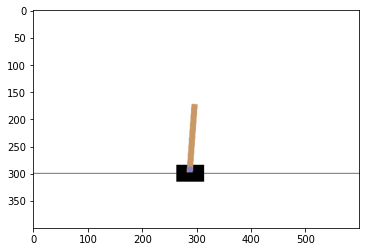

In [98]:
simulate()